# Statistical Foundations of Machine Learning: Project

## Introduction
This notebook was created as part of the coursework for Statistical Foundations of Machine Learning, a master's course in Artificial Intelligence at the VUB (Vrije Universiteit Brussel). In this interactive notebook we will try to answer 3 research questions by applying ML algorithms to both synthetic and real datasets.

Before this running this notebook, please install the following python packages: 
- numpy
- scipy
- scikit-learn
- ...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
from scipy import stats
import scipy as sp

Generating a synthetic classification dataset in 2 dimensions. Datapoints are uniformly distributed in the 2 dimensional input plane. The classification of the points is decided by a user defined separation_boundary.

In [3]:
def generate_uniform_classification_data(n, separation_boundary, x0min=0, x0max=1, x1min=0, x1max=1):
    x0distr = stats.uniform(loc=x0min, scale=x0max-x0min)
    x1distr = stats.uniform(loc=x1min, scale=x1max-x1min)
    x0s = x0distr.rvs(size=n)
    x1s = x1distr.rvs(size=n)
    X = np.array(list(zip(x0s, x1s)))
    y = np.sign([separation_boundary(xi) for xi in X])
    y = np.where(y == 0, 1, y)
    return X, y

def generate_normally_distributed_points(n, means, co_variances):
    distr = stats.multivariate_normal(means, co_variances)
    ### Code from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal    
    
    return distr.rvs(size=n)

def plot_labeled_data(X, y):
    posX = X[np.where(y == 1)]
    negX = X[np.where(y == -1)]
    plt.plot(posX[:,0], posX[:,1], 'r.')
    plt.plot(negX[:,0], negX[:,1], 'b.')


## Research Question 1

## Research Question 2
The second question we aim to answer in this notebook, is how the distribution of input-variables of datapoints affects a regression algorithm's ability to fit the data. This is an interesting thing to investigate because real data is not always uniformly distributed. For example a people's heights tend to be normally distributed. In this section, we will fit multiple regression algorithms to several synthetic datasets that had their datapoints generated from different types of distributions. We will be working with only 1 input dimension since this makes it easier for us to plot the data.

In [4]:
### Some functions to help us visualise ###
def plot_function(function, range=(0, 1), ax=plt):
    line = ax.plot(np.linspace(range[0], range[1], 100), function(np.linspace(range[0], range[1], 100)))
    return ax, line[0]

def plot_data(x, y, ax=plt):
    line = ax.scatter(x, y)
    return ax, line

def plot_data_cdf(x, ax=plt):
    sorted = np.sort(x)
    p = np.arange(len(x)) / (len(x) - 1)
    line = ax.plot(sorted, p)
    return ax, line[0]

def plot_distr_cdf(distr, range=(0, 1), ax=plt):
    return plot_function(distr.cdf, range, ax)

def plot_distr_pdf(distr, range=(0, 1), ax=plt):
    return plot_function(distr.pdf, range, ax)

def plot_distrs(x, distr, range=(0, 1), ax=plt):
    _, line = plot_data_cdf(x, ax)
    line.set_label("Data CDF")
    _, line = plot_distr_cdf(distr, range=range, ax=ax)
    line.set_label("Distribution CDF")
    ax.legend()
    return ax

def minmax(x):
    return (min(x), max(x))

def multiply_fig_size(fig, row, col):
    size = np.array(fig.get_size_inches()) * np.array([col, row])
    fig.set_size_inches(size)
    return fig


We will test the algorithms on various distributions of input data. The distributions we will be using are a uniform distribution (as a baseline), a normal distribution and an exponential distribution. We shift, scale and truncate the distributions to be in the range [0, 1]. The range in which the generated points fall, which is decided by the distribution, influences which part of the target function the algorithm will try to fit. By bringing each of these distributions to the same range, we ensure a fair comparison. The distributions are scaled by a factor 0.2, at which point around 99% of the values for the non-truncated version will fall in the range [0, 1].

To visualise how these distributions generate their datapoints, we plot the probability density and cummulative density functions for each of them in the cell below. I also include graphs visualising the similarity between the distributions and their truncated version in the interval [0, 1].

A normal distribution with mean 0.5 and std 0.2 has 99% of its values in the range [-0.01516586070978021, 1.01516586070978]
A exponential distribution with scale 0.2 has 99% of its values in range [0, 0.9210340371976182]


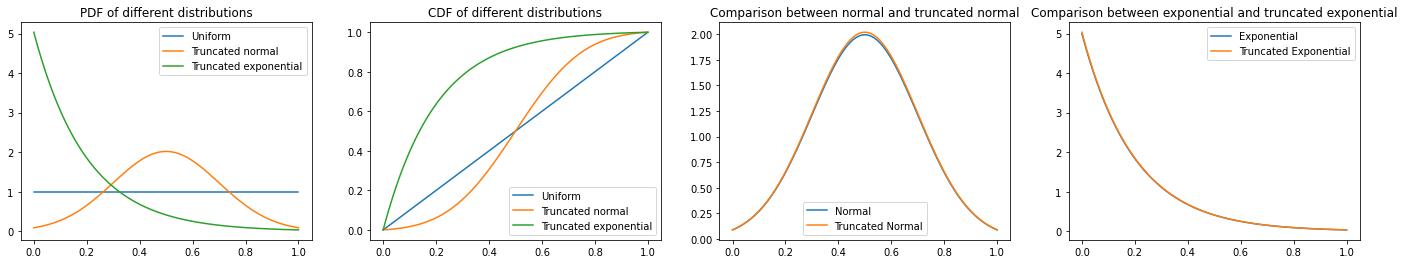

In [5]:
# Uniform distribution
def uniform():
    return stats.uniform()

# Truncated normal distribution
def trunc_norm(mean=0.5, std=0.2):
    a, b, mu, sig = 0, 1, mean, std
    ### --- Code adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html#notes
    a, b = (a - mu) / sig, (b - mu) / sig
    ### --- It updates the boundaries of the normal distribution based on the mean and std
    xdistr = stats.truncnorm(a, b, loc=mu, scale=sig)
    return xdistr

# Truncated exponential
def trunc_expon(scale=0.2):
    return stats.truncexpon(1/scale, loc=0, scale=scale)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
multiply_fig_size(fig, 1, 4)

# Visualise uniform distribution
uniform_distr = uniform()
_, line = plot_distr_pdf(uniform_distr, ax=ax1)
line.set_label("Uniform")
_, line = plot_distr_cdf(uniform_distr, ax=ax2)
line.set_label("Uniform")

# Visualise truncated normal distribution
mean, std = 0.5, 0.2
trunc_norm_distr = trunc_norm(mean, std)
uniform_distr = uniform()
_, line = plot_distr_pdf(trunc_norm_distr, ax=ax1)
line.set_label("Truncated normal")
_, line = plot_distr_cdf(trunc_norm_distr, ax=ax2)
line.set_label("Truncated normal")

normal_distr = stats.norm(loc=mean, scale=std)
print(f"A normal distribution with mean {mean} and std {std} has 99% of its values in the range [{normal_distr.ppf(0.005)}, {normal_distr.ppf(0.995)}]")

# Plot difference between normal and truncated_normal
plot_distr_pdf(normal_distr, ax=ax3)[1].set_label("Normal")
plot_distr_pdf(trunc_norm_distr, ax=ax3)[1].set_label("Truncated Normal")
ax3.set_title("Comparison between normal and truncated normal")
ax3.legend()

# Visualise truncated exponential distribution
scale = 0.20
trunc_expon_distr = trunc_expon(scale)
_, line = plot_distr_pdf(trunc_expon_distr, ax=ax1)
line.set_label("Truncated exponential")
_, line = plot_distr_cdf(trunc_expon_distr, ax=ax2)
line.set_label("Truncated exponential")

expon_distr = stats.expon(scale=scale)
print(f"A exponential distribution with scale {scale} has 99% of its values in range [0, {expon_distr.ppf(0.99)}]")

# Plot difference between exponential and exponential
plot_distr_pdf(expon_distr, ax=ax4)[1].set_label("Exponential")
plot_distr_pdf(trunc_expon_distr, ax=ax4)[1].set_label("Truncated Exponential")
ax4.set_title("Comparison between exponential and truncated exponential")
ax4.legend()


distrs = [uniform_distr, trunc_norm_distr, trunc_expon_distr]
distr_names = ["uniform", "truncated normal", "truncated exponential"]

ax1.set_title("PDF of different distributions")
ax2.set_title("CDF of different distributions")
ax1.legend()
ax2.legend()


### Algorithms
We'll attempt to fit the target functions using different regression algorithms.
The first algorithms we'll use is the Kernel Ridge Regression algorithm. As the name suggests this is a Ridge Regression algorithm that uses the kernel trick to transform data to a (higher dimension) feature space. The Ridge Regression algorithm fits the data


#### SVR
The first algorithm we'll be using is the support vector regressor (SVR). It is an extension to the support vector classifier (SVM) algorithm. 

Let $D = \{d_i | 1 \leq i \leq N\}$ be our training samples and $y = \{y_i | 1 \leq i \leq N\}$ their target values. The SVR learns a hypothesis

$$ f(x) = \sum_{i=1}^N(\alpha_i^{*} - \alpha_i)*(d_ix + 1)^p + b $$

Where the values for $\alpha_i, \alpha_i^{*}$ and $b$ are learned during training. The SVR searches the hypothesis space for the optimal values for all these parameters. Optimal values for these parameters are those that minimise the following objective function:

$$ C\sum_{i=1}^NL_\epsilon(y_i - F(d_i, w)) + ||w||^2 $$

The objective is a sum of 2 terms. The first being the $\epsilon$-insensitive loss between the prediction and target value. The second term is a regularisation term. The amount of regularisation can be controller by changing the $C$ parameter.
The $\epsilon$-insensitive loss function $L_\epsilon$ used in the objective function is defined as follows

$$ 
L_\epsilon(x) = \left\{
    \begin{array}{ll}
        0 & if |x| < \epsilon \\
        |x| - \epsilon & if |x| \geq \epsilon
    \end{array}
\right.
$$

In the case of our objective function, the loss will be zero if the error ($|y_i - F(d_i, w)|$) is smaller than $\epsilon$, otherwise the loss will be how much the error exceeds this limit.This can be interpreted as creating an $\epsilon$-wide boundary around $F$. Any point $(d_i, y_i)$ which lies in this boundary will not contribute to the objective function, and its corresponding $\alpha_i^{*}$ and $\alpha_i$ will be zero. Otherwise, atleast one of two will be non-zero, and we call $d_i$ a support vector. 

We can definitely see the similarities between this and the soft-margin SVM. In the soft-margin SVM, we have a margin that we want points to lie outside, and penalise the objective functions for any points that lie inside the margin. With SVR we do the opposite, we have a margin ($\epsilon$-wide boundary) that we want points to lie inside, and panalise the objective functions for any points that lie outside of it.

Finally, we can extend this algorithm to higher dimensional feature spaces using the kernel trick.

*(source: https://proceedings.neurips.cc/paper/1996/file/d38901788c533e8286cb6400b40b386d-Paper.pdf)*

Whereas many other ML-algorithms try to minimise $E_{in}$ subject to $|w| < \epsilon$, support vector machines instead directly attempt to minimise $|w|$, putting the condition on $E_{in}$ instead.

#### KNN
A K-Nearest-Neighbour (KNN) algorithm predicts the value for a point based on the points it is close to, its neighbours. Specifically, these algorithms provide the user with a tunable hyperparameter $k$ which determines how many of these neighbours we want to take into account.

A KNN classifier classifies a point as the majority label among its $k$ neighbours. Let $\{d_i | 1 \leq i \leq k\}$ be the $k$ training samples nearest to $x$ and $y = \{y_i | 1 \leq i \leq k\}$ their classifications.
$$  
    F(x) = sign(\sum_{i=1}^k y_i)
$$
Turning this into a regressor is simple. Instead of taking the sign of the sum of the output of our neighbours, we take the mean. Let $\{d_i | 1 \leq i \leq k\}$ be the $k$ training samples nearest to $x$ and $y = \{y_i | 1 \leq i \leq k\}$ their values.
$$  
    F(x) = \frac{\sum_{i=1}^k y_i}{k}
$$

*(source: )*

In [155]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

algorithm_names = ["SVR", "KNN"]

### Experiments on synthetic datasets
We can now start training and evaluating the algorithms using the different distributions of datapoints. We start by choosing a target function we want our models to learn. We then generate equally sized datasets for each of the different data distributions we are examining. Each algorithm is then trained on each dataset. 

Finally we evaluate the trained models. Since we know the target function in these examples, we can directly evaluate the models by generating some datapoints and their corresponding values. We choose these points uniformly spread over the [0, 1] domain. However, the original datasets was not always drawn from a uniform distribution. To fix this, we weigh the contribution of each datapoint to the final score by its value in the probability density function of the distribution we are examining. This way points that would have had only a small chance of being generate, contribute less to the final score. We repeat this process for multiple iterations and average over the scores for each algorithm-distribution pair to reduce variance on our results.

In [122]:
def generate_regression_data(n, target, xdistr=stats.uniform(), noise_var=0):
    noise_distr = stats.norm(scale=noise_var)
    x = xdistr.rvs(n)
    y = target(x)
    noise = noise_distr.rvs(n)
    y = y + noise
    return x, y

def plot_prediction(x, y, target_function, model, range=False, ax=plt):
    prediction = make_prediction_function(model)
    if not range:
        range = minmax(x)
    # Plot the target function
    if target_function:
        _, line = plot_function(target_function, range=range, ax=ax)
        line.set_label("Target function")
        line.set_color("r")
        line.set_linestyle("--")
    # Plot the predicted curve
    _, line = plot_function(prediction, range=range, ax=ax)
    line.set_label("Predicted")
    # Plot datapoints (+ support vectors in case of SVR)
    if type(model) == skl.svm._classes.SVR:
        support_vector_idx = model.support_
        support_vector_mask = np.zeros(len(x), dtype=bool)
        support_vector_mask[support_vector_idx] = True

        _, line = plot_data(np.array(x)[np.where(np.invert(support_vector_mask))], np.array(y)[np.where(np.invert(support_vector_mask))], ax=ax)
        line.set_label("Data points")

        support_vectors = np.array(x)[np.where(support_vector_mask)]
        support_vector_ys = np.array(y)[np.where(support_vector_mask)]
        _, line = plot_data(support_vectors, support_vector_ys, ax=ax)
        line.set_color("r")
        line.set_label("Support Vectors")
    else:
        _, line = plot_data(x, y, ax=ax)
        line.set_label("Data points")
    ax.legend()
            
def fit_models(x, y, svr_param={}, knn_param={}):
    #fit the SVR
    svr = SVR(**svr_param)
    svr.fit(X=x.reshape(-1, 1), y=y)

    #fit the KNN
    knn = KNeighborsRegressor(**knn_param)
    knn.fit(X=x.reshape(-1, 1), y=y)

    return svr, knn

def plot_results(result_dicts, axss):
    for result, distr, name, axs in zip(result_dicts.values(), distrs, result_dicts.keys(), axss):
        plot_results_for_distribution(result, distr, name, axs)    

def plot_results_for_distribution(result, distr, distr_name, axs):
    x, y, target_function, svr, knn = result['x'], result['y'], result['target'], result['svr'], result['knn']
    assert(len(axs) == 3)
    ax1, ax2, ax3 = axs
    if ax1:
        plot_distrs(x, distr, range=(0, 1), ax=ax1)
        ax1.set_title(f"CDFs for {distr_name} distribution")
    if ax2:
        plot_prediction(x, y, target_function, svr, range=(0, 1), ax=ax2)
        ax2.set_title(f"SVR on {distr_name} distribution")
    if ax3:
        plot_prediction(x, y, target_function, knn, range=(0, 1), ax=ax3)
        ax3.set_title(f"KNN on {distr_name} distribution")
    
def make_prediction_function(model):
    return lambda x: model.predict(x.reshape(-1, 1))

from sklearn.metrics import mean_squared_error

def run_1_iteration(target_function, ns, svr_param={}, knn_param={}):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)
    test_y = target_function(test_x)
    results = {}

    if not isinstance(ns, list):
        ns = [ns, ns, ns]
    
    for n, distr, name in zip(ns, distrs, distr_names):
        x, y = generate_regression_data(n, target_function, xdistr=distr, noise_var=0.1)
        svr, knn = fit_models(x, y, svr_param, knn_param)

        weights = distr.pdf(test_x)
        #svr_score, knn_score = svr.score(test_x, test_y, weights), knn.score(test_x, test_y, weights)
        svr_score = mean_squared_error(test_y, svr.predict(test_x), sample_weight=weights)
        knn_score = mean_squared_error(test_y, knn.predict(test_x), sample_weight=weights)
        results[name] = {"target":target_function, "x":x, "y":y, "svr":svr, "knn":knn, "svr_score":svr_score, "knn_score":knn_score}

    return results

def plot_iteration_results(iteration_results):
    nrows, ncols = 3, 3
    fig, axss = plt.subplots(3, 3)
    multiply_fig_size(fig, nrows, ncols)
    plot_results(iteration_results, axss) 

    scores = [[distr_name, distr_result['svr_score'], distr_result['knn_score']] for distr_name, distr_result in iteration_results.items()]
    df = pd.DataFrame(np.reshape(scores, (-1, 3)), columns=["Distributions", "SVR", "KNN"])
    df = df.astype({"SVR": float, "KNN": float})
    print(df)

def average_results(results):
    scores = [
        [[distr_name, distr_result['svr_score'], distr_result['knn_score']] for distr_name, distr_result in result.items()] for result in results
    ]
    df = pd.DataFrame(np.reshape(scores, (-1, 3)), columns=["Distributions", "SVR", "KNN"])
    df = df.astype({"SVR": float, "KNN": float})
    df = df.groupby("Distributions")[["SVR", "KNN"]].mean()
    df = df.reindex(["uniform", "truncated normal", "truncated exponential"])
    return df


For the experiments on synthetical data, the target function will be a simple linear function.

In [9]:
# Linear target function
num_datapoints = 50
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))

In the cell below you can see the results after running 100 iterations. We can see that on average models trained on uniform distribution of points perform better those trained on the normal and exponential distributions. Looking at the graphs we can see why this is. 

For SVR the fault lies with the chosen kernel function. When there are few datapoints, the model overfits, causing dips or rises in the target function. The same thing happens for the KNN algorithm. At the extrema, where there are fewer datapoints, the decision function flattens out.

Remember that during evaluation the evaluation points are weighted with their corresponding value in the PDF. For example for the normal distribution, this means points near the edges contribute less to the total error, and the points in the center contribute more. Even with this taken into account, the errors for the normal and exponential distribution are still higher than those for the uniform. This suggests that the extra accuracy gained in the center, does not make up for the accuracy lost near the edges.

		---- Average over 100 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.001796  0.002392
truncated normal       0.002700  0.002727
truncated exponential  0.004576  0.004250

		---- Results for iteration 1 (mean_squared_error) ----
           Distributions       SVR       KNN
0                uniform  0.003290  0.002354
1       truncated normal  0.003095  0.002083
2  truncated exponential  0.002263  0.004543


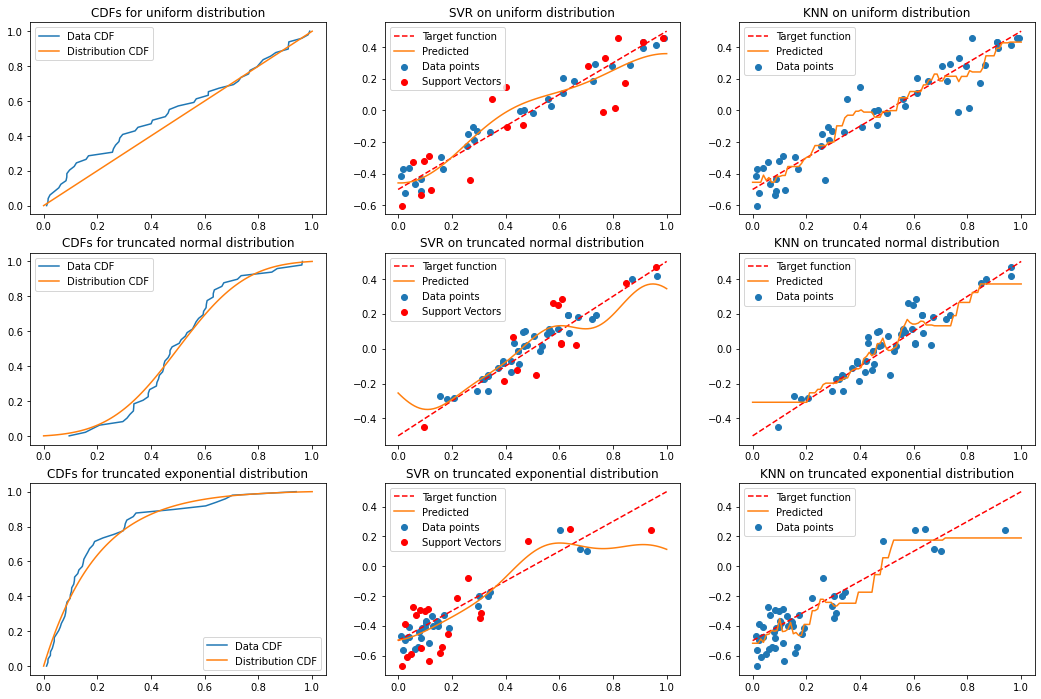

In [10]:
# I invite the reader to change the values below to look at the results for a different iterations
chosen_iteration = 1

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)
print(f"\n\t\t---- Results for iteration {chosen_iteration} (mean_squared_error) ----")
plot_iteration_results(results[chosen_iteration])

The cell below shows that the we get similar results as above when:

1. We have more data
2. We have less data
3. We're using a linear kernel for SVR

In [121]:
print("-------- Baseline --------")
df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

print("-------- More training data --------")
num_datapoints = 100
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

print("-------- Less training data --------")
num_datapoints = 25
n_iterations = 200
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

print("-------- Using a linear kernel --------")
num_datapoints = 50
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {'kernel':'linear'}, {}))

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

-------- Baseline --------
		---- Average over 100 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.000736  0.002583
truncated normal       0.000820  0.002889
truncated exponential  0.001006  0.004085
-------- More training data --------
		---- Average over 100 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.000941  0.002116
truncated normal       0.001439  0.002296
truncated exponential  0.001916  0.002626
-------- Less training data --------
		---- Average over 200 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.004674  0.004923
truncated normal       0.007000  0.004878
truncated exponential  0.007366  0.007007
-------- Using a linear kernel --------
		---- Average over 100 iterations (mean_sq

From these experiments it is seems that on a linear dataset having uniformly distributed training data is preferable over a normally or exponentially distributed data. Now we can ask ourselves what we can do if our data isn't uniformly distributed. One solution would be to simply collect more data, preferably with the aim of making the dataset more uniformly distributed. However, it is not always possible to get more data so we'll have to look for another solution. We could also do the opposite; we could drop some of the data. This would be a valid solution if the accuracy you gain by making the dataset uniformly distributed is greater than the accuracy you lose by reducing the size of the training data.

**EXPAND ON THIS**

-------- Reduced number of uniformly distributed points VS more non-uniformly distributed --------
		---- Average over 100 iterations (mean_squared_error) (Normal and Expontential have 25% more data) ----
                             SVR       KNN
Distributions                            
uniform                0.000200  0.002025
truncated normal       0.000142  0.002015
truncated exponential  0.000143  0.002007

		---- Results for iteration 0 (mean_squared_error) ----
           Distributions       SVR       KNN
0                uniform  0.000339  0.002661
1       truncated normal  0.000139  0.001536
2  truncated exponential  0.000204  0.001867


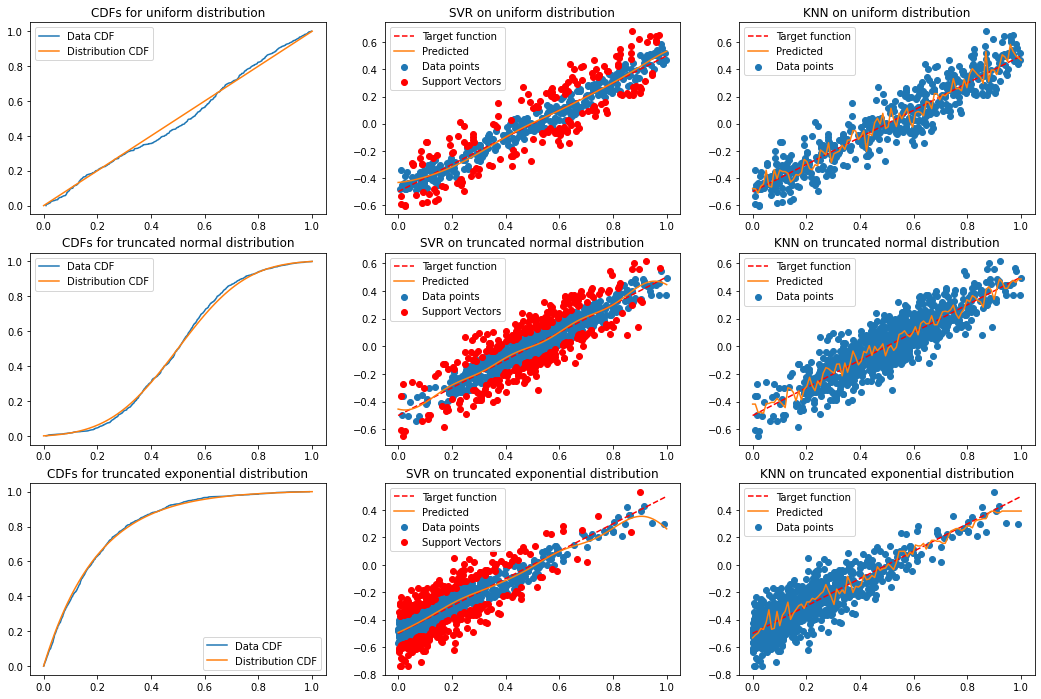

In [154]:
print("-------- Reduced number of uniformly distributed points VS more non-uniformly distributed --------")
num_datapoints = [500, 1000, 1000]
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))


df = average_results(results)
chosen_iteration = 0
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) (Normal and Expontential have 25% more data) ----\n", df)
print(f"\n\t\t---- Results for iteration {chosen_iteration} (mean_squared_error) ----")
plot_iteration_results(results[chosen_iteration])

### Example on real dataset
Answering this research question is a challenging thing to do with real datasets since we don't have control over the distribution of the data. Nonetheless I will still apply these 2 algorithms to some real normally distributed datasets. The dataset we will be using consists of all kinds of different body measurements for possums. The plots in the cell below show how different features in the dataset compare to a normal distribution (with mean and standard deviation the mean and standard deviation of the data). Headlength, total length, tail length, eye size, chest girth and belly are all appear to be normally distributed. Using a statistical test we can confirm that the distributions of these features are not significantly different from a normal distribution.

*(data source = https://www.kaggle.com/datasets/abrambeyer/openintro-possum)*

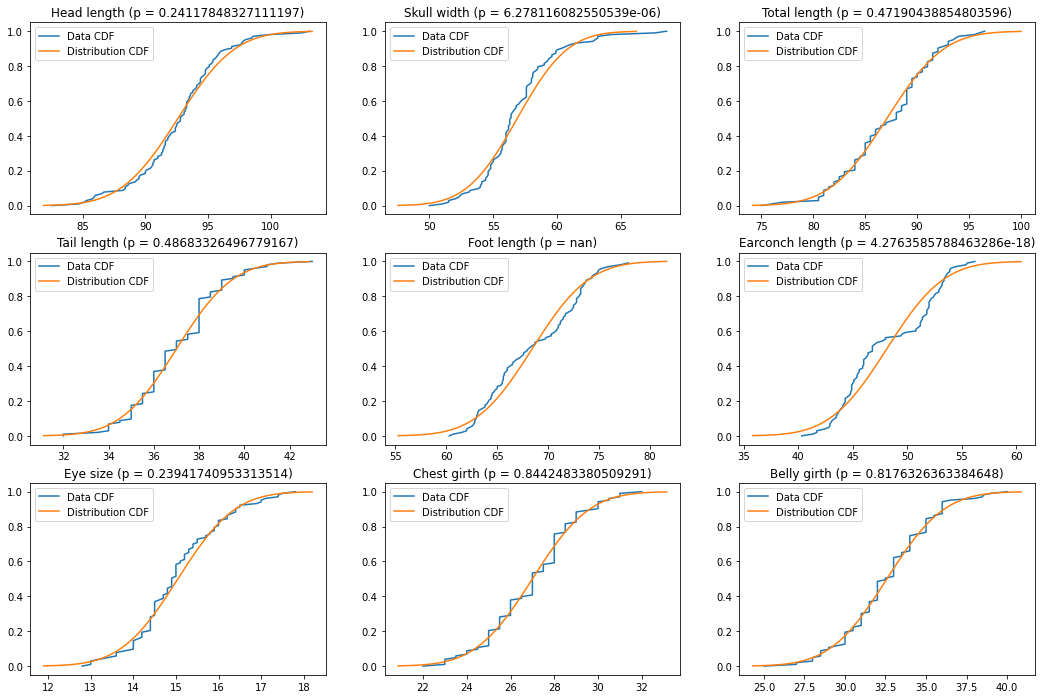

In [118]:
possum_data = pd.read_csv("./possum.csv")
#print(possum_data.head())
features = ["hdlngth", "skullw", "totlngth", "taill", "footlgth", "earconch", "eye", "chest", "belly"]
feature_display_name = ["Head length", "Skull width", "Total length", "Tail length", "Foot length", "Earconch length", "Eye size", "Chest girth", "Belly girth"]
fig, axs = plt.subplots(len(features)//3, 3)
multiply_fig_size(fig, len(features)//3, 3)

for feature, name, ax in zip(features, feature_display_name, axs.flatten()):
    feature_data = possum_data[feature]
    ax.set_title(f"{name} (p = {stats.normaltest(feature_data)[1]})")
    mean, std = feature_data.mean(), feature_data.std()
    length_distr = stats.norm(loc=mean, scale=std)
    plot_distrs(feature_data, length_distr, (mean-3*std, mean+3*std), ax)

We find many different regression tasks for this dataset. In this notebook we will look to predict a possum's skull width based on its total length.

(<module 'matplotlib.pyplot' from 'c:\\Users\\Admin\\anaconda3\\envs\\SFoML\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <matplotlib.collections.PathCollection at 0x129d7b8ff10>)

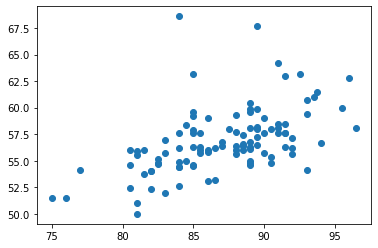

In [17]:
x = possum_data["totlngth"].to_numpy()
y = possum_data["skullw"].to_numpy()
plot_data(x, y)

Since we don't know the target function in this scenario, we can't generate datapoints for testing, and we'll have to set some of our data aside as a test set for later evaluation.

In [84]:
from sklearn.model_selection import train_test_split
# Setting the random state so the experiments results will be the same if the notebook is ran again
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)
x_train = x_train.reshape((-1, 1))
x_test = x_test.reshape((-1, 1))

We can now fine-tune the hyperparameters for our model. This can easily be done using a grid search with cross-validation on the training set. For SVR I manually checked every kernel to see which one performed best, which in this case was the linear kernel.

In [119]:
from sklearn.model_selection import GridSearchCV
# Kernels:  Linear  (0.39)
#           RBF     (0.33)
#           Poly    (0.38) (Really slow + didn't fine tune 'degree' hyperparameter)
#           Sigmoid (-0.03)
svr_gs = \
    GridSearchCV(SVR(), \
        {
            'epsilon': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4],
            'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100],
            'kernel': ['linear']
        })
svr_gs_result = svr_gs.fit(x_train, y_train)

knn_gs = \
    GridSearchCV(KNeighborsRegressor(), \
        {
            'n_neighbors': [1, 2, 3, 5, 10, 15, 20, 25, 30],
            'weights': ['uniform', 'distance'],
        })
knn_gs_result = knn_gs.fit(x_train, y_train)

Best parameters for SVR: {'C': 0.1, 'epsilon': 2, 'kernel': 'linear'}, score: 0.39053408225082437
Best parameters for KNN: {'n_neighbors': 15, 'weights': 'uniform'}, score: 0.3082990091265153


C:\Users\Admin\AppData\Local\Temp\ipykernel_3352\4004540796.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\Admin\AppData\Local\Temp\ipykernel_3352\4004540796.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


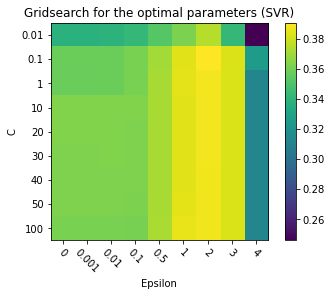

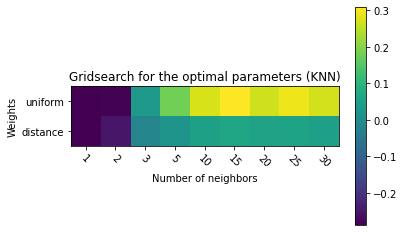

In [120]:
fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)

# Plot results for SVR
Epsilon, C = svr_gs_result.param_grid["epsilon"], svr_gs_result.param_grid["C"]

im = ax1.imshow(svr_gs_result.cv_results_["mean_test_score"].reshape(len(C), len(Epsilon)))
fig1.colorbar(im)

ax1.set_xlabel("Epsilon")
ax1.set_xticks(range(len(Epsilon)))
ax1.set_xticklabels(Epsilon, rotation=-45)
ax1.set_ylabel("C")
ax1.set_yticks(range(len(C)))
ax1.set_yticklabels(C)
ax1.set_title("Gridsearch for the optimal parameters (SVR)")

# Plot results for KNN
n_neighbors, weights = knn_gs_result.param_grid["n_neighbors"], knn_gs_result.param_grid["weights"]

im = ax2.imshow(np.transpose(knn_gs_result.cv_results_["mean_test_score"].reshape(len(n_neighbors), len(weights))))
fig2.colorbar(im)
ax2.set_xlabel("Number of neighbors")
ax2.set_xticks(range(len(n_neighbors)))
ax2.set_xticklabels(n_neighbors, rotation=-45)
ax2.set_ylabel("Weights")
ax2.set_yticks(range(len(weights)))
ax2.set_yticklabels(weights)
ax2.set_title("Gridsearch for the optimal parameters (KNN)")

fig1.show()
fig2.show()

svr_best_params = svr_gs_result.best_params_
print(f"Best parameters for SVR: {svr_gs_result.best_params_}, score: {svr_gs_result.best_score_}")

knn_best_params = knn_gs_result.best_params_
print(f"Best parameters for KNN: {knn_gs_result.best_params_}, score: {knn_gs_result.best_score_}")

Finally we examing the final hypothesis. Since we don't know the target function (if that were the case, why are we learning from data?), we can't calculated $E_out$. We can however estimate its value by evaluating on the test set. The scoring metric we use here (and during parameter tuning) is the coefficient of determination $R^2$. This is a measure of how well our model explains the variance in the data. A value of 1 means that the model perfectly predicts the data, and value of 0 means the model predicts the same outcome for every input. Since we have a value of around 0.12 for both models, this means the model does explain some of the variance in the data, but not all of it.

In the case of the KNN algorithm, we see the same effect of the normally distributed data as we had in the synthetic dataset experiments. For low and high length values, the prediction curve starts to flatten out, even though we might expect the target function to be linear (assuming possum's heads grow as they grow in length).

SVR's score on the test set: 0.12633035321124908
KNN's score on the test set: 0.12559070280229845


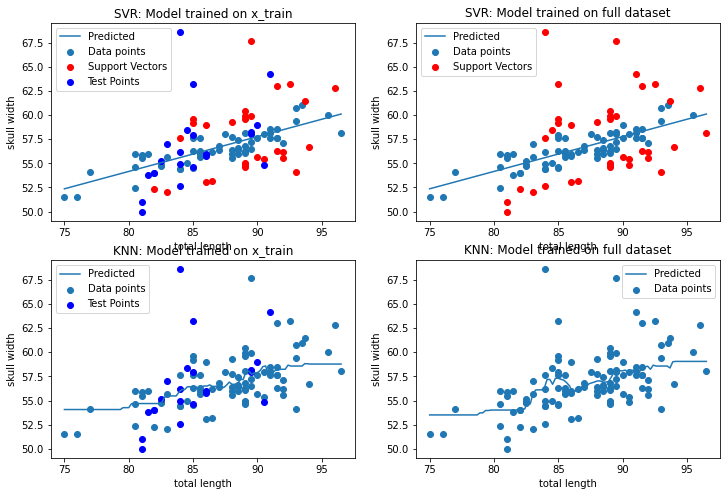

In [116]:
# Create some plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
multiply_fig_size(fig, 2, 2)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel("total length")
    ax.set_ylabel("skull width")

# Fit models using the optimal parameters
svr = SVR(**svr_best_params)
svr.fit(x_train, y_train)
knn = KNeighborsRegressor(**knn_best_params)
knn.fit(x_train, y_train)

# Score the models on the test set
score = svr.score(x_test, y_test)
print(f"SVR's score on the test set: {score}")
score = knn.score(x_test, y_test)
print(f"KNN's score on the test set: {score}")

# Plot results for the train_data model...
ax1.set_title("SVR: Model trained on x_train")
plot_prediction(x_train, y_train, False, svr, ax=ax1)
ax1.scatter(x_test, y_test, c="b", label="Test Points")
ax1.legend()
ax3.set_title("KNN: Model trained on x_train")
plot_prediction(x_train, y_train, False, knn, ax=ax3)
ax3.scatter(x_test, y_test, c="b", label="Test Points")
ax3.legend()

# And the full data model
ax2.set_title("SVR: Model trained on full dataset")
plot_prediction(x, y, False, SVR(**svr_best_params).fit(x.reshape((-1, 1)), y), ax=ax2)
ax4.set_title("KNN: Model trained on full dataset")
plot_prediction(x, y, False, KNeighborsRegressor(**knn_best_params).fit(x.reshape((-1, 1)), y), ax=ax4)

### Conclusion
It is preferable to have uniformly distributed data when doing regression. If the data you have is not uniformly distributed, and no new data can be collected, just use the data you already have.
